### 1. Heat pipe design

a) Express the problem in generic geometric form: <br>
\begin{equation}
\begin{aligned}
& \underset{T,r >0}{\text{min}}
& & a_4^{-1} T^{-1} r^{-2} \\
& \text{s.t.} & &  {{a_1}\over{C_{max}}} T r w^{-1} + {{a_2}\over{C_{max}}} r + {{a_3}\over{C_{max}}} r w\le 1 \\
& & &  {{T_{min}} T^{-1}} \le 1 \\
& & &  {1\over{T_{max}}} T \le 1 \\
& & &  {{r_{min}} r^{-1}} \le 1 \\
& & &  {1\over{r_{max}}} r \le 1 \\
& & &  {{w_{min}} w^{-1}} \le 1 \\
& & &  {1\over{w_{max}}} w \le 1 \\
& & &  10 w r^{-1} \le 1 \\
& & &  T,r,w > 0 \\
\end{aligned}
\end{equation}

Convert the problem into a convex optimization problem:
<p> Define $x = log(T), y = log(r), z = log(w)$ </p>
\begin{equation}
\begin{aligned}
& \underset{x,y,z}{\text{min}}
& & -log(a_4)-x-2y \\
& \text{s.t.} & &  log(e^{log({{a_1}\over{C_{max}}}) + x + y - z} + e^{log({{a_2}\over{C_{max}}}) + y} + 
e^{log({{a_3}\over{C_{max}}}) + y + z})\le 0 \\
& & &  log10 + z - y \le 0 \\
& & &  logT_{min} \le x \le logT_{max} \\
& & &  logr_{min} \le y \le logr_{max} \\
& & &  logw_{min} \le z \le logw_{max} \\
\end{aligned}
\end{equation}

In [264]:
#b
using JuMP,Ipopt
m = Model(solver=IpoptSolver())
@variable(m, x)
@variable(m, y)
@variable(m, z)
@NLconstraint(m,log(exp(log(1/500) + x + y - z) + exp(log(1/500) + y) + 
exp(log(1/500) + y + z)) <= 0)
@constraint(m, log(10) + z - y <= 0)
@constraint(m,x >= 0)
@constraint(m,y >= 0)
@constraint(m,z >= 0)
@objective(m,Min,- x - 2y)
solve(m)
;

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        8
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        5
        inequality constraints with only lower bounds:        3
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

In [265]:
println("Optimal: ", getobjectivevalue(m))

println("T = ", exp(getvalue(x)))
println("r = ", exp(getvalue(y)))
println("w = ", exp(getvalue(z)))
getvalue(x)
;

Optimal: -10.845561179359784
T = 23.840239436706664
r = 46.390428093528406
w = 4.639042794383609


### 2. The Huber loss

In [266]:
#a
using JuMP,Gurobi
data_x = [1:15...]
data_y = [6.31 3.78 5.12 1.71 2.99 4.53 2.11 3.88 4.67 26 2.06 23 1.58 2.17 0.02]'

m = Model(solver=GurobiSolver(OutputFlag=0,BarHomogeneous=1))
@variable(m, a)
@variable(m, b)
@objective(m, Min, sum((data_y[i] - a*data_x[i] - b)^2 for i=1:15))

solve(m)
println(getobjectivevalue(m))
var_a1 = getvalue(a);
var_b1 = getvalue(b);
;

Academic license - for non-commercial use only
819.9155504761902


In [267]:
m = Model(solver=GurobiSolver(OutputFlag=0,BarHomogeneous=1))
@variable(m, a)
@variable(m, b)
@objective(m, Min, sum((data_y[i] - a*data_x[i] - b)^2 for i=1:15 if i != 12&& i!=10))
solve(m)
println(getobjectivevalue(m))
var_a2 = getvalue(a);
var_b2 = getvalue(b);
;

Academic license - for non-commercial use only
18.291874043062165


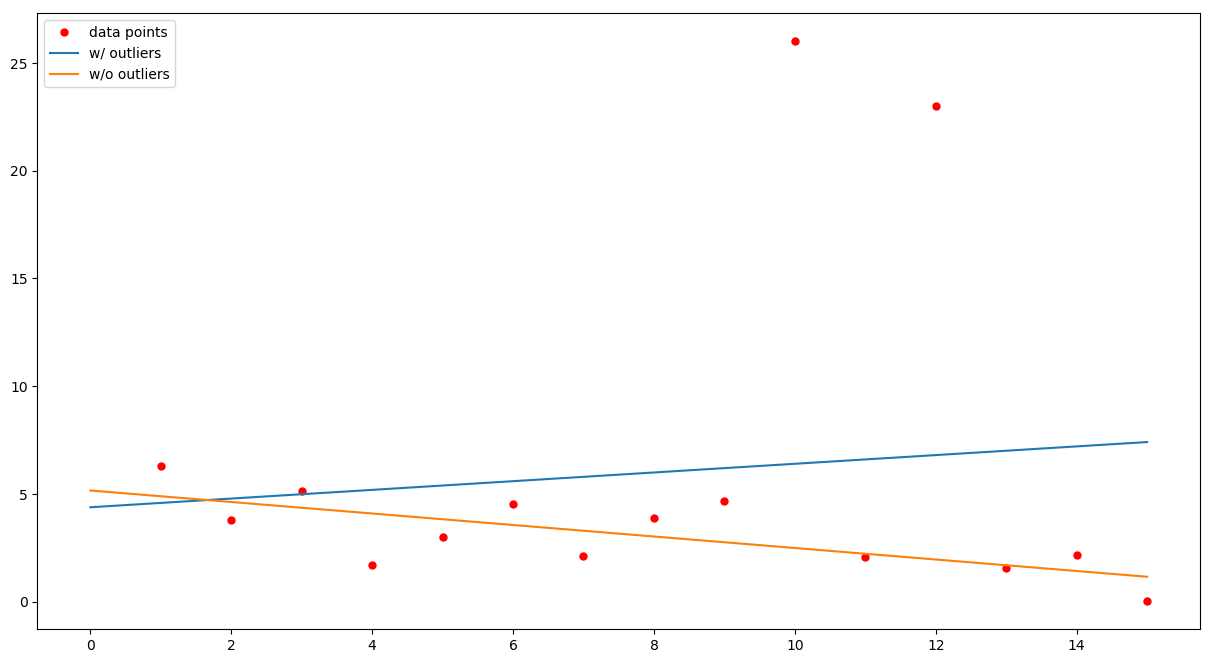

In [268]:
using PyPlot
figure(figsize=(15,8))
x = range(0,stop=15,length=15)
plot(data_x,data_y,"r.", markersize=10)
plot(x,var_a1*x .+ var_b1)
plot(x,var_a2*x .+ var_b2)
legend(["data points","w/ outliers", "w/o outliers"], loc="upper left");
;

In [272]:
#b
using JuMP,Gurobi
data_x = [1:15...]
data_y = [6.31 3.78 5.12 1.71 2.99 4.53 2.11 3.88 4.67 26 2.06 23 1.58 2.17 0.02]'

m = Model(solver=GurobiSolver(OutputFlag=0,BarHomogeneous=1))
@variable(m, a)
@variable(m, b)
@variable(m, t[1:15])
@constraint(m, data_y - a.*data_x- b .<= t)
@constraint(m, -t .<=data_y - a.*data_x- b)
@objective(m, Min, sum(t))
solve(m)
println(getobjectivevalue(m))
var_a3 = getvalue(a)
var_b3 = getvalue(b)
;

Academic license - for non-commercial use only
57.11454545454546


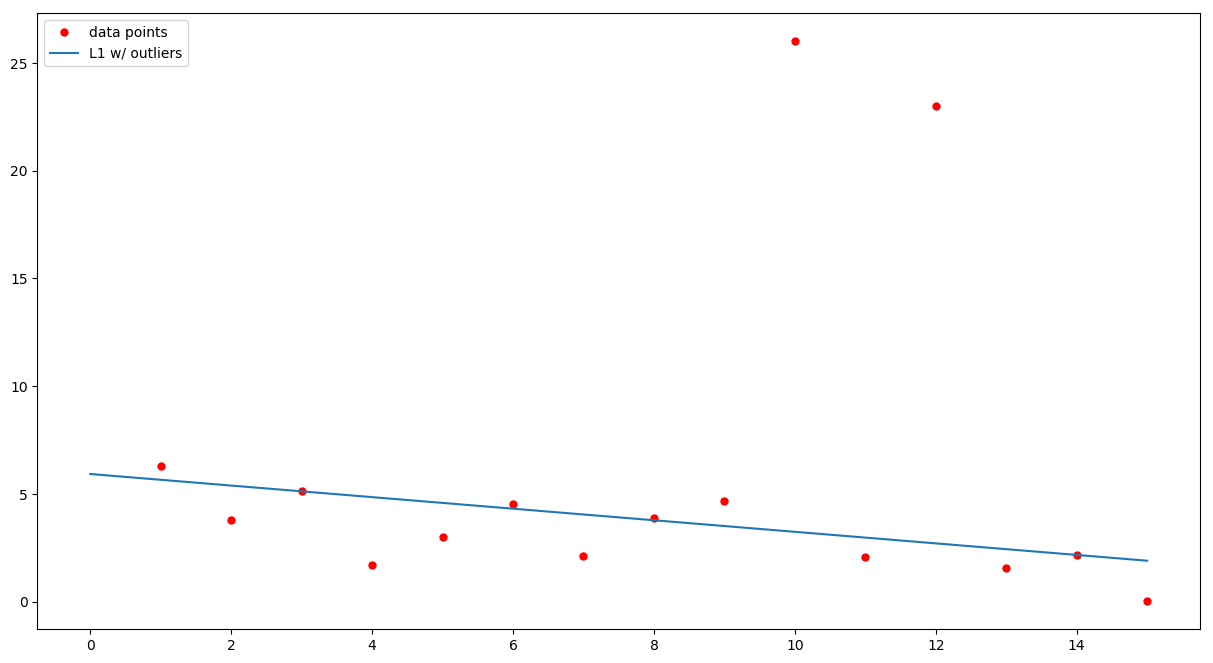

In [273]:
using PyPlot
figure(figsize=(15,8))
x = range(0,stop=15,length=15)
plot(data_x,data_y,"r.", markersize=10)
plot(x,var_a3*x .+ var_b3)
legend(["data points","L1 w/ outliers"], loc="upper left");
;

L1 handles outliers better than least squares because the effect of the distance from the linear fit to outliers in the square form will be grow much greater than the effect in linear form. Therefore, for l2 to minimize the objective, it has to move as closer to the outliers as possible to reduce the extra cost. But l1 treats any point uniformly so the outliers will have less effect on the precision of the best linear fit.

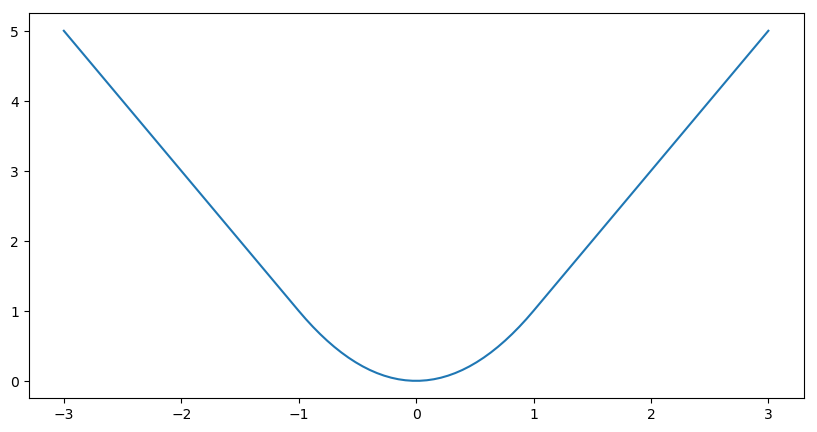

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

In [276]:
#c Verification
using JuMP, Gurobi, PyPlot

y = zeros(0)
for x in range(-3,stop = 3,length = 100) 
    m = Model(solver=GurobiSolver(OutputFlag=0,BarHomogeneous=1))
    @variable(m, v)
    @variable(m, w)
    @constraint(m, abs(x) <= w+v)
    @constraint(m,  v >= 0)
    @constraint(m, w <= 1)
    @objective(m, Min, w^2 + 2v)
    solve(m)
    append!(y, getobjectivevalue(m));
end
figure(figsize=(10,5))
x = range(-3,stop = 3,length = 100) 
plot(x,y)
;

In [277]:
#find linear fit using huber lost function
using JuMP,Gurobi
data_x = [1:15...]
data_y = [6.31 3.78 5.12 1.71 2.99 4.53 2.11 3.88 4.67 26 2.06 23 1.58 2.17 0.02]'

m = Model(solver=GurobiSolver(OutputFlag=0,BarHomogeneous=1))
@variable(m, v[1:15])
@variable(m, w[1:15])
@variable(m, a)
@variable(m, b)
@constraint(m, data_y - a.*data_x- b .<= w+v)
@constraint(m, -(w+v) .<=data_y - a.*data_x- b)
@constraint(m,  v .>= 0)
@constraint(m, w .<= 1)
@objective(m, Min, sum(w.^2 + 2v))
solve(m)
println(getobjectivevalue(m))
var_a4 = getvalue(a)
var_b4 = getvalue(b)
;

Academic license - for non-commercial use only
101.61186329513943


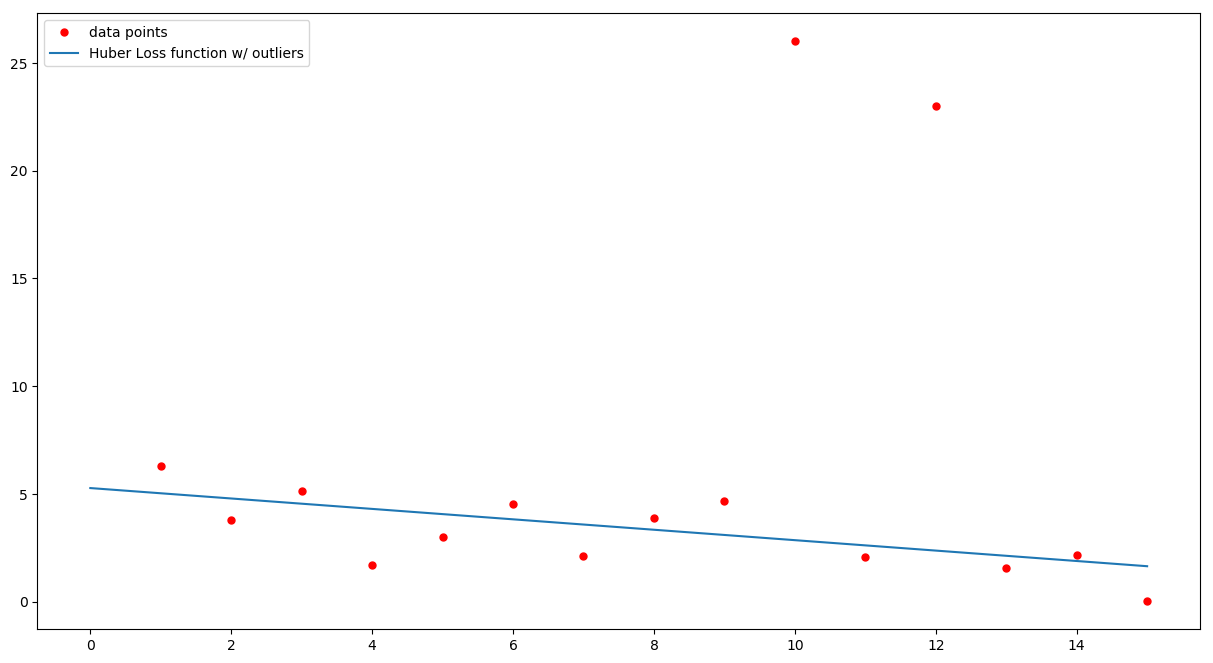

-0.24172477295267544
5.272477090715872


In [278]:
using PyPlot
figure(figsize=(15,8))
x = range(0,stop=15,length=15)
plot(data_x,data_y,"r.", markersize=10)
plot(x,var_a4*x .+ var_b4)
legend(["data points","Huber Loss function w/ outliers"], loc="upper left");
;
println(var_a4)
println(var_b4)

### 3. Enclosing circle


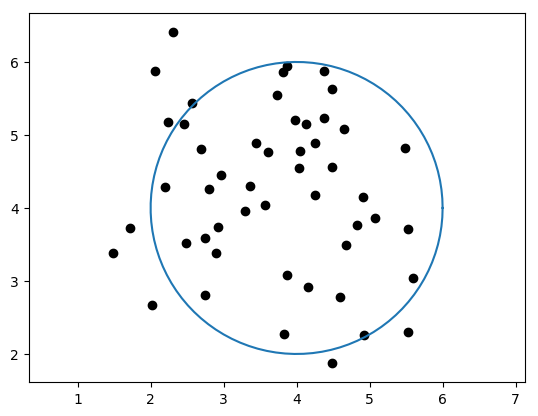

In [295]:
using PyPlot
X = 4 .+ randn(2,50) # generate 50 random points
t = range(0,stop=2pi,length=100) # parameter that traverses the circle
r = 2; x1 = 4; x2 = 4 # radius and coordinates of the center
plot( x1 .+ r*cos.(t), x2 .+ r*sin.(t)) # plot circle radius r with center (x1,x2)
scatter( X[1,:], X[2,:], color="black") # plot the 50 points
axis("equal") # make x and y scales equal
;

This problem can be viewed as to create a smallest circle on the graph such that all points are located inside, i.e., all points are constrained to have euclidean distance to the center less than the radius.

In [296]:
using Gurobi
m = Model(solver=IpoptSolver())
@variable(m, r >= 0)
@variable(m, x1 >= 0)
@variable(m, x2 >= 0)
for i in 1:50
    @NLconstraint(m, sqrt((X[1,i]-x1)^2 + (X[2,i]-x2)^2)  <= r)
end
@objective(m,Min, r)
solve(m)
println(getvalue(r))

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      150
Number of nonzeros in Lagrangian Hessian.............:      150

Total number of variables............................:        3
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       50
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       50

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

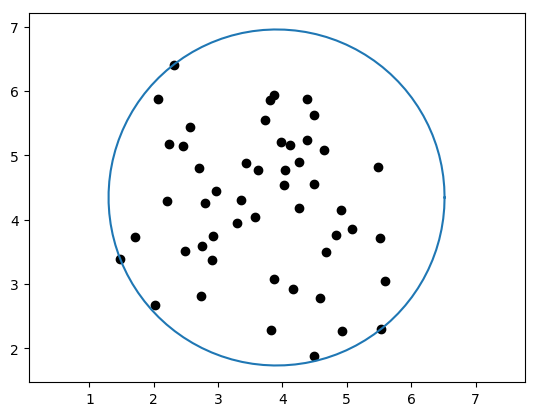

In [297]:
using PyPlot
t = range(0,stop=2pi,length=100) # parameter that traverses the circle
r = getvalue(r); x1 = getvalue(x1); x2 = getvalue(x2) # radius and coordinates of the center
plot( x1 .+ r*cos.(t), x2 .+ r*sin.(t)) # plot circle radius r with center (x1,x2)
scatter( X[1,:], X[2,:], color="black") # plot the 50 points
axis("equal") # make x and y scales equal
;

In [294]:
Pkg.installed()


Dict{String,Union{Nothing, VersionNumber}} with 12 entries:
  "CSV"           => v"0.4.3"
  "Clp"           => v"0.6.1"
  "JuMP"          => v"0.18.5"
  "NamedArrays"   => v"0.9.2"
  "LinearAlgebra" => nothing
  "Ipopt"         => v"0.5.4"
  "IJulia"        => v"1.16.0"
  "Plots"         => v"0.23.0"
  "PyPlot"        => v"2.6.3"
  "Cbc"           => v"0.6.0"
  "Gurobi"        => v"0.6.0"
  "Mosek"         => v"0.9.10"